In [1]:
import sys
lib_path = '/home/jovyan/libs'
sys.path.insert(0, lib_path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import load_from_disk
from transformers import WhisperProcessor, WhisperForConditionalGeneration

from tqdm import tqdm
import importlib

import notebooks.audio_utils as audio

In [4]:
dataset = load_from_disk("/home/jovyan/tedlium/validation.hf").with_format("torch").select(range(100))

In [5]:
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en", output_attentions=True).to("cuda")
processor = WhisperProcessor.from_pretrained("openai/whisper-tiny.en")

/home/jovyan/libs/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [6]:
def inference(audio_tensor, model, processor, is_longform=False, skip_special_tokens=False):
    if not is_longform:
        inputs = processor(audio_tensor, return_tensors="pt", sampling_rate=16_000)
        input_features = inputs.input_features.to(model.device)
        res = model.generate(input_features, output_attentions=True, return_dict_in_generate=True)
        decoded = processor.batch_decode(res["sequences"], skip_special_tokens=skip_special_tokens)
        return (decoded[0], res.encoder_attentions, res.decoder_attentions, res.cross_attentions)
    else:
        inputs = processor(audio_tensor, return_tensors="pt", truncation=False, padding="longest", return_attention_mask=True, sampling_rate=16_000)
        input_features = inputs.to(model.device)
        res = model.generate(**input_features, output_attentions=True, return_dict_in_generate=True)
        decoded = processor.batch_decode(res, skip_special_tokens=skip_special_tokens)
        return (decoded[0], None, None, None)

In [101]:
print(dataset[10])

{'audio': tensor([ 0.0033,  0.0018,  0.0003,  ...,  0.0005, -0.0027, -0.0020]), 'text': 'if they get surrounded they notice that too they might get a little flustered and they can also sense their motion and tilt'}


In [102]:
example = dataset[10]["audio"]

"""
Promising examples: 2, 3, 4, 10

Not promising examples: 1
""";

In [103]:
encoder_limit = int(example.size(0) / 16000 * 50) + 1
encoder_limit

466

In [60]:
audio.play_audio(example)

In [104]:
res, _, _, c_attns = inference(example, model, processor, skip_special_tokens=True)

In [64]:
def plot_attns(attns, rows, cols, figsize=(30, 10), filename=None):
    attns = [a.cpu().squeeze(0) for a in attns]
    blocks = len(attns)
    heads = attns[0].size(0)
    assert rows * cols == blocks * heads
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    pbar = tqdm(range(blocks * heads), leave=True, ncols=0)
    
    for idx in pbar:
        i, j = idx // cols, idx % cols
        x, y = idx // heads, idx % heads
        sns.heatmap(attns[x][y,:,:], cmap="viridis", ax=ax[i][j])
        ax[i][j].set_title(f"Block {x + 1} Head {y + 1}")
        pbar.refresh()

    # plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()

In [65]:
filename = None

encoder_filename = None if not filename else filename + "_encoder.png"
encoder_truncated_filename = None if not filename else filename + "_encoder_truncated.png"
decoder_filename = None if not filename else filename + "_decoder.png"
cross_filename = None if not filename else filename + "_cross.png"
cross_truncated_filename = None if not filename else filename + "_cross_truncated.png"

# Cross Attentions

In [66]:
c_attns_stacked = torch.stack([torch.stack(c).squeeze() for c in c_attns[1:]]).permute(1, 2, 0, 3)
# plot_attns(c_attns_stacked, 8, 3, figsize=(30, 80), filename=cross_filename)

100% 24/24 [00:38<00:00,  1.60s/it]


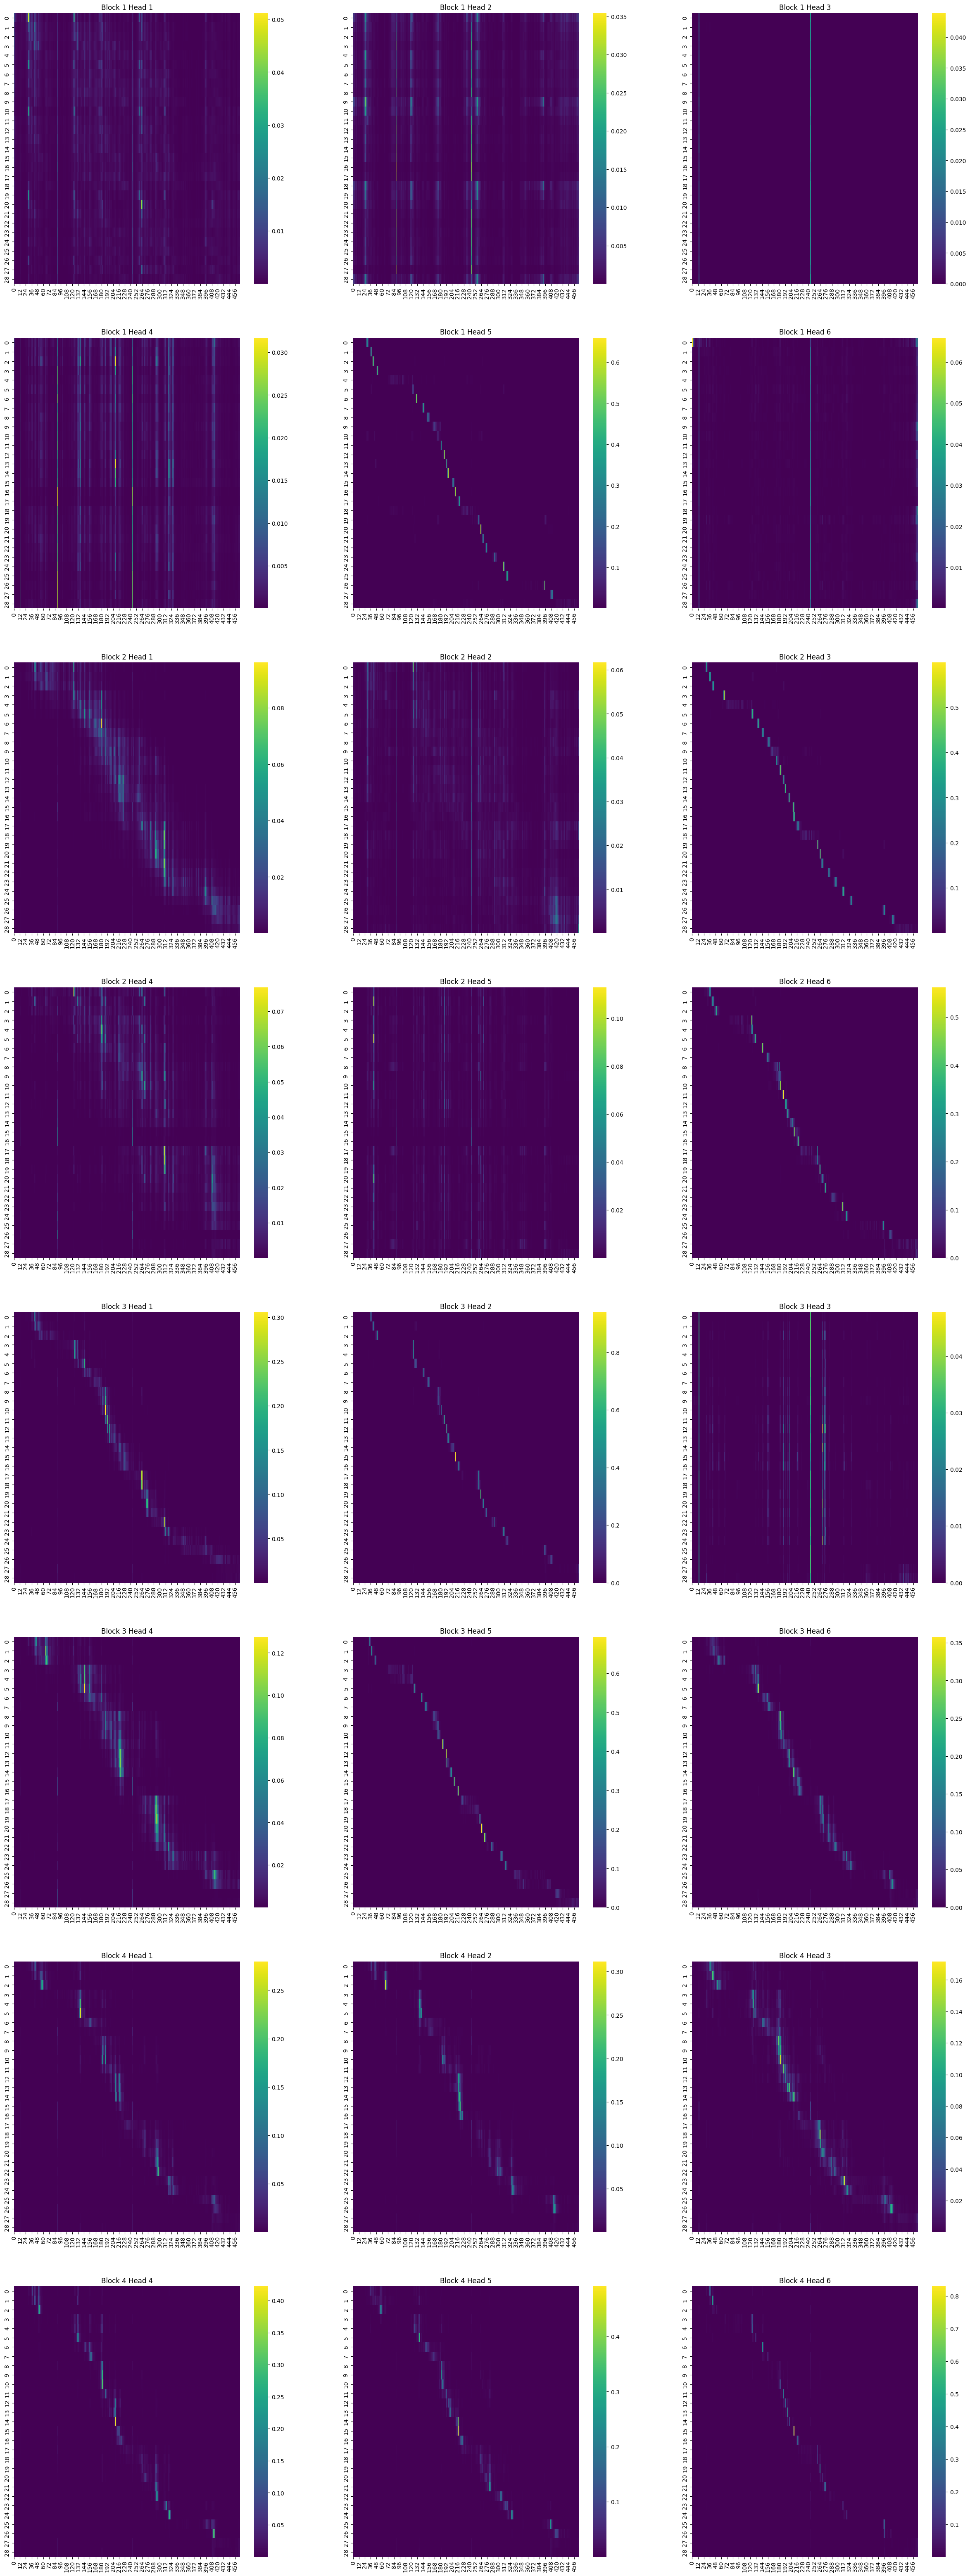

In [105]:
c_attns_stacked_cutoff = torch.stack([torch.stack(c).squeeze() for c in c_attns[1:]]).permute(1, 2, 0, 3)[:, :, :, :encoder_limit]
plot_attns(c_attns_stacked_cutoff, 8, 3, figsize=(30, 80), filename=cross_truncated_filename)

In [96]:
def get_timestamp(audio, attn, lim):
    maxi, mini = attn.max(), attn.min()
    normalised_attn = (attn - mini) / (maxi - mini)
    masked = torch.where(normalised_attn >= lim, 1.0, 0.0)
    indices = masked.nonzero()[:, 1].unique().cpu()
    seconds = indices * 0.02 * 16_000
    return indices, seconds

def plot_spikes(audio, attn, lim, figsize=(20, 6)):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    sns.heatmap(attn.detach().cpu(), cmap="viridis", ax=ax[0])
    
    indices, seconds = get_timestamp(audio, attn, lim)
    print(indices)

    ax[1].plot(audio)
    ax[1].vlines(seconds, -1, 1, color="r")
    
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()

tensor([ 14,  90, 244])


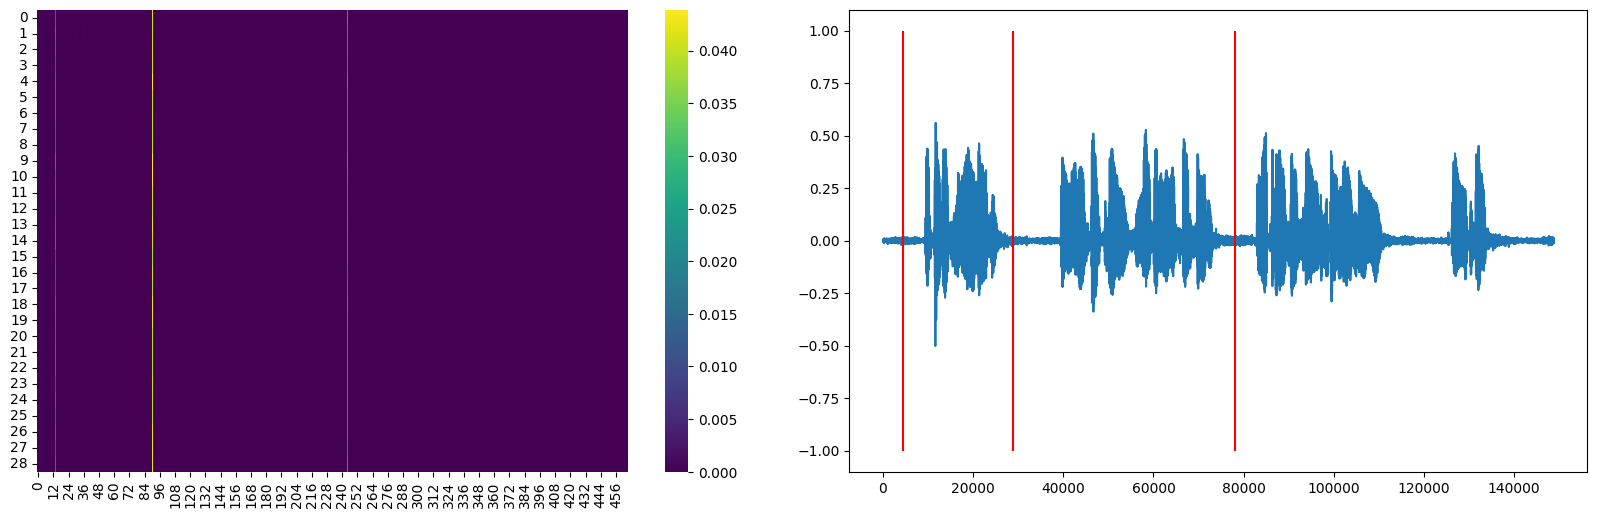

In [106]:
plot_spikes(example, c_attns_stacked_cutoff[0, 2], 0.2, figsize=(20, 6))

In [59]:
audio.play_audio(example[start:])